In [1]:
import numpy as np
from scipy.io.wavfile import read
from scipy import signal
from librosa import feature, load, frames_to_time
import matplotlib.pyplot as plt
from sklearn import preprocessing
import pandas as pd

## Data Science

### Basics of Statistical Modeling

ANY **model** is understood to be an approximation or emulation of a real-world object, event, or process. 

The underlying idea behind virtually all statistical models **is to try to find a relationship between measured features or variables and the probability of a particular outcome.** If it can predict the outcome with perfect certainty, then the model would appear to be a successful model of the real-world phenomenon. That is, presumably you have captured ALL the variables (and their relations) necessary to understand or predict a 'real world' event.

In reality, a model rarely predicts things with perfect accuracy, especially if it involves any phenomenon which is known to contain a great deal of randomness and/or an unknown number of variables (e.g., human behavior).

### Prepare the data and create a feature vector

Before we start building models, let's take a look at the data by constructing our own.

I am going to use the tracks from your last activity to walk through the first steps.

When we begin, we want to make sure all of our data is in the same format. This involves can involve cutting the length of files/samples, normalizing the amplitude, or resampling.

In [3]:
# resample, scale, crop files

(data1, fs) = load("../audio/BobMarley_track1.wav", sr=44100)
(data2, fs) = load('../audio/MilesDavis_track2.wav', sr=44100)

print(data1.shape, data2.shape)

(1322922,) (1377004,)


In [7]:
ind = len(data1)
data1 = data1[:ind]
data2 = data2[:ind]
print(data1.shape, data2.shape)


(1322922,) (1322922,)


In [8]:
def normalize(x):
    n = x/abs(x.max())
    return(n)

In [9]:
data1 = normalize(data1)
data2 = normalize(data2)

Once all the data is in the same format, we can begin exploring the data to construct our feature vector.

We can start by calculating our various features across our data. We'll start with just a few ZCR, RMSE, and centroid.

In [5]:


#RMSE
hop_length = 2048
frame_length = 4096
rmse_1 = np.array([])
for i in range(0,len(data1),hop_length):
    rms_i = np.sqrt(np.mean(abs(data1[i:i+frame_length]**2)))
    rmse_1 = np.append(rmse_1,rms_i)

#ZCR
zcr_1 = feature.zero_crossing_rate(data1.astype(float), hop_length=1024)

#centroid
centroid_1 = feature.spectral_centroid(y=data1.astype(float), sr=fs)

In [6]:
hop_length = 2048
frame_length = 4096
rmse_2 = np.array([])
for i in range(0,len(data2),hop_length):
    rms_i = np.sqrt(np.mean(abs(data2[i:i+frame_length]**2)))
    rmse_2 = np.append(rmse_2,rms_i)

#ZCR
zcr_2 = feature.zero_crossing_rate(data2.astype(float), hop_length=1024)

#centroid
centroid_2 = feature.spectral_centroid(y=data2.astype(float), sr=fs)

When we calculate each of these features then combine, we get a multidimensional array due to the framing over time. 

Often when building feature vectors for statistical models, we want to summarize the features for a given data point by taking the mean and variance (standard deviation). This creates an overall summary of the features in our data point.

In [10]:
centroid_2.shape

(1, 2690)

In [13]:
# find mean and std of features

mean_rms_1 = rmse_1.mean()
std_rms_1 = rmse_1.std()

mean_zcr_1 = zcr_1.mean()
std_zcr_1 = zcr_1.std()

mean_centroid_1 = centroid_1.mean()
std_centroid_1 = centroid_1.std()


In [12]:
# find mean and std of features

mean_rms_2 = rmse_2.mean()
std_rms_2 = rmse_2.std()

mean_zcr_2 = zcr_2.mean()
std_zcr_2 = zcr_2.std()

mean_centroid_2 = centroid_2.mean()
std_centroid_2 = centroid_2.std()


Note, we may not always want just the mean as it loses information for us. We have no idea of temporal changes across the features, just "the summary". Depending on the goals of the model, we may need to modify or use additional segmentation, but for now we'll stick with the mean.

Additionally, when working with the mean variance, we typically need to rescale again. Many regression and machine learning models assume certain distributions of data. If a feature has a variance that is orders of magnitude larger that others, it might dominate the model (i.e., make it seem very important) and make the estimator unable to learn from other features propertly (also it will take more iterations to "fit" the model).

Even if a feature is already scaled to beween 0 and 1 (or -1 and 1) it will have done so at the level of the computation (on song or even frame by frame level). Therefore, it can still be beneficial to standardize across the entire feature column across the whole dataset. 

By setting the mean to zero and standard deviation to one (standardization or "mean normalization") we will optimize our results.

In [ ]:
# This is done across the full data columns before taking the mean/std

df = pd.DataFrame([[1, 2.12], [3.356, 4.567],[1.25, 2.67]])
scaler = preprocessing.StandardScaler()
scaled_df = scaler.fit_transform(df)

# or manually (though you may get division by zero errors in rare cases)
normalized_df=(df-df.mean())/df.std()

Once we have all of data point's features computed and scaled, we can insert it into a feature vector. So far we have worked in numpy arrays, but these can get unruly and they do not work well for reading in existing datasets.

We will use Pandas data frames to hold our datasets. Pandas can do lots of convenient row/column operations.

In [19]:
# create feature dataframe

# we can create from a arrays/lists
data_list = [[mean_rms_1, std_rms_1, mean_zcr_1, std_zcr_1, mean_centroid_1, std_centroid_1], [mean_rms_2, std_rms_2, mean_zcr_2, std_zcr_2, mean_centroid_2, std_centroid_2]]
df = pd.DataFrame(data_list, columns = ['mean_rms', 'std_rms', 'mean_zcr', 'std_zcr', 'mean_centroid', 'std_centroid'])
df


,mean_rms,std_rms,mean_zcr,std_zcr,mean_centroid,std_centroid
0,0.087593,0.055396,0.050378,0.043845,2239.560193,1192.634428
1,0.046411,0.036610,0.035790,0.027033,3183.853395,1447.929322


In [ ]:
# we can create from dictionaries


No matter how we build it, we will are aiming for the same result, a 2d "table" where each row represents a datapoint or sample and each column contains that samples feature information.

Now instead of expressing our song as a length 1322922 array or a multidimensional array of features over time, we are representing it with a few summary features (6 in this case). 

Just to review: 
- sample -> one song
- frame -> short time slice of our song
- feature -> measurement per frame
- summary statistic -> reduced the features over time into one representation
- feature vector -> summary statistic per sample

### Exploring Your Data

Often you will not be building your own datasets, but creating models based on existing data. (Though you will still have to create feature vectors for testing and using your model)

We are going to use a popular MIR dataset called GTZAN for in class demos. It is primarily used for genre classification and contains 10 genres with 100 songs each. The dataset includes 2 csvs, from *Kaggle* "One file has for each song (30 seconds long) a mean and variance computed over multiple features that can be extracted from an audio file. The other file has the same structure, but the songs were split before into 3 seconds audio files (this way increasing 10 times the amount of data we fuel into our classification models). With data, more is always better."

https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification?resource=download

In [20]:
# read in CSV into dataframe

df = pd.read_csv('../Datasets/features_30_sec.csv')
df

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,rock.00095.wav,661794,0.352063,0.080487,0.079486,0.000345,2008.149458,282174.689224,2106.541053,88609.749506,...,45.050526,-13.289984,41.754955,2.484145,36.778877,-6.713265,54.866825,-1.193787,49.950665,rock
996,rock.00096.wav,661794,0.398687,0.075086,0.076458,0.000588,2006.843354,182114.709510,2068.942009,82426.016726,...,33.851742,-10.848309,39.395096,1.881229,32.010040,-7.461491,39.196327,-2.795338,31.773624,rock
997,rock.00097.wav,661794,0.432142,0.075268,0.081651,0.000322,2077.526598,231657.968040,1927.293153,74717.124394,...,33.597008,-12.845291,36.367264,3.440978,36.001110,-12.588070,42.502201,-2.106337,29.865515,rock
998,rock.00098.wav,661794,0.362485,0.091506,0.083860,0.001211,1398.699344,240318.731073,1818.450280,109090.207161,...,46.324894,-4.416050,43.583942,1.556207,34.331261,-5.041897,47.227180,-3.590644,41.299088,rock


For the purposes of today's class (and classes in the future), I'm going to reduce this dataframe down

In [21]:
df.columns

Index(['filename', 'length', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean',
       'rms_var', 'spectral_centroid_mean', 'spectral_centroid_var',
       'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean',
       'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var',
       'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo',
       'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean',
       'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var',
       'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean',
       'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var',
       'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean',
       'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var',
       'mfcc16_mean', 'mfcc16_var', 'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean',
       'mfcc18_var', 'mfcc19_mean', 'mfcc19_var', 'mfcc20_mean', 'mfcc20_var',
  

In [22]:
columns_to_keep = ['filename', 'length', 'label', 'rms_mean', 'spectral_centroid_mean', 'spectral_bandwidth_mean', 'rolloff_mean', 'zero_crossing_rate_mean']
df = df[columns_to_keep]
df

,filename,length,label,rms_mean,spectral_centroid_mean,spectral_bandwidth_mean,rolloff_mean,zero_crossing_rate_mean
0,blues.00000.wav,661794,blues,0.130228,1784.165850,2002.449060,3805.839606,0.083045
1,blues.00001.wav,661794,blues,0.095948,1530.176679,2039.036516,3550.522098,0.056040
2,blues.00002.wav,661794,blues,0.175570,1552.811865,1747.702312,3042.260232,0.076291
3,blues.00003.wav,661794,blues,0.141093,1070.106615,1596.412872,2184.745799,0.033309
4,blues.00004.wav,661794,blues,0.091529,1835.004266,1748.172116,3579.757627,0.101461
...,...,...,...,...,...,...,...,...
995,rock.00095.wav,661794,rock,0.079486,2008.149458,2106.541053,4253.557033,0.089227
996,rock.00096.wav,661794,rock,0.076458,2006.843354,2068.942009,4149.338328,0.097664
997,rock.00097.wav,661794,rock,0.081651,2077.526598,1927.293153,4031.405321,0.121823
998,rock.00098.wav,661794,rock,0.083860,1398.699344,1818.450280,3015.631004,0.048724


In [23]:
genres = ['blues', 'rock', 'pop']
df = df[df['label'].isin(genres)]
df

,filename,length,label,rms_mean,spectral_centroid_mean,spectral_bandwidth_mean,rolloff_mean,zero_crossing_rate_mean
0,blues.00000.wav,661794,blues,0.130228,1784.165850,2002.449060,3805.839606,0.083045
1,blues.00001.wav,661794,blues,0.095948,1530.176679,2039.036516,3550.522098,0.056040
2,blues.00002.wav,661794,blues,0.175570,1552.811865,1747.702312,3042.260232,0.076291
3,blues.00003.wav,661794,blues,0.141093,1070.106615,1596.412872,2184.745799,0.033309
4,blues.00004.wav,661794,blues,0.091529,1835.004266,1748.172116,3579.757627,0.101461
...,...,...,...,...,...,...,...,...
995,rock.00095.wav,661794,rock,0.079486,2008.149458,2106.541053,4253.557033,0.089227
996,rock.00096.wav,661794,rock,0.076458,2006.843354,2068.942009,4149.338328,0.097664
997,rock.00097.wav,661794,rock,0.081651,2077.526598,1927.293153,4031.405321,0.121823
998,rock.00098.wav,661794,rock,0.083860,1398.699344,1818.450280,3015.631004,0.048724


When first starting out with a data set, it’s always a good idea to go through the data itself and see what you can already learn. The best way to do this is to make a lot of graphs and plots. Ensure you choose the correct plot type given your data. 

For example, if your data is categorical, it can be misleading to use a line graph, since lines will connect data points where there could never be any values in between. In this case, a bar plot is better.

E.g., let's say that I wanted to look at the means of five different features across all my existing categories of data

<AxesSubplot: title={'center': 'RMS Mean by label'}, xlabel='label'>

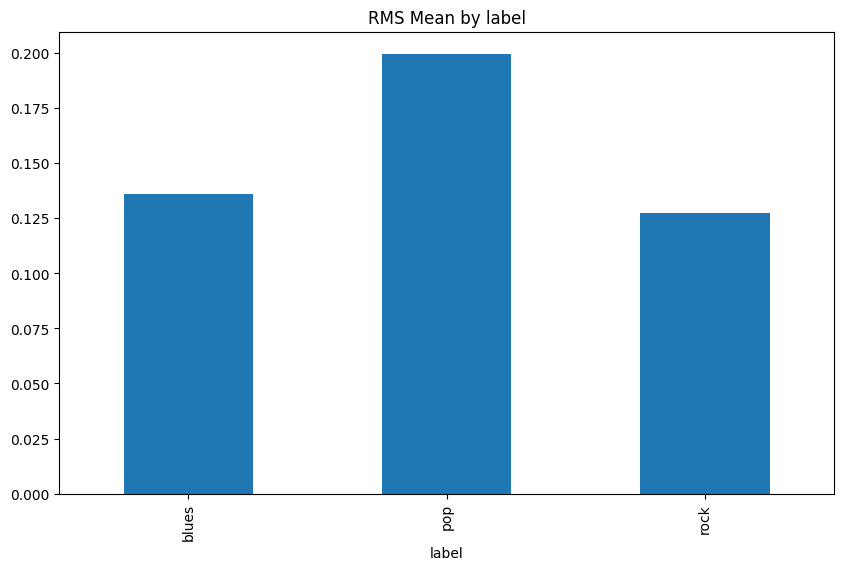

In [24]:
genre_rms = df.groupby('label')['rms_mean'].mean()
genre_rms.plot.bar(figsize=(10, 6), title='RMS Mean by label')

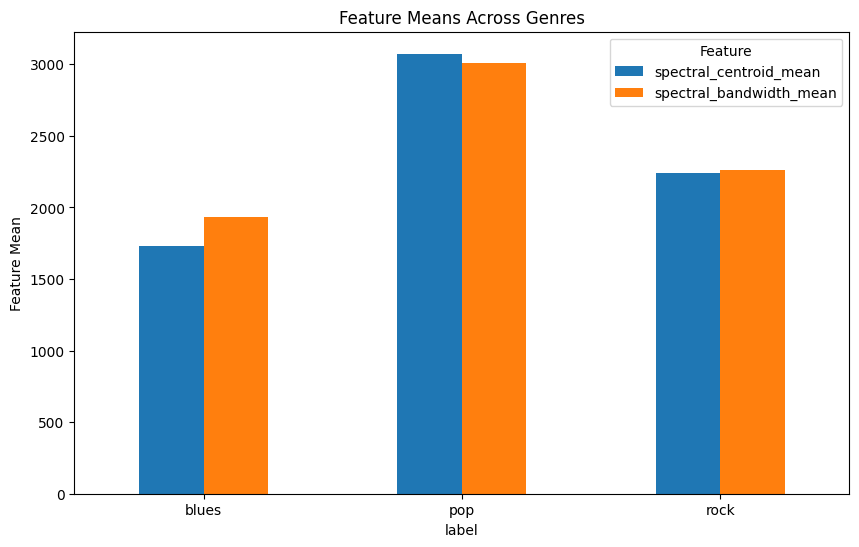

In [25]:
grouped = df.groupby("label").mean(numeric_only=True)
features = [
    "spectral_centroid_mean",
    "spectral_bandwidth_mean"
]

grouped_features = grouped[features]
grouped_features.plot.bar(figsize=(10, 6), title='Feature Mean by label')
plt.ylabel("Feature Mean")
plt.title("Feature Means Across Genres")
plt.xticks(rotation=0)
plt.legend(title="Feature")
plt.show()

<AxesSubplot: title={'center': 'RMS Mean by label'}, xlabel='label'>

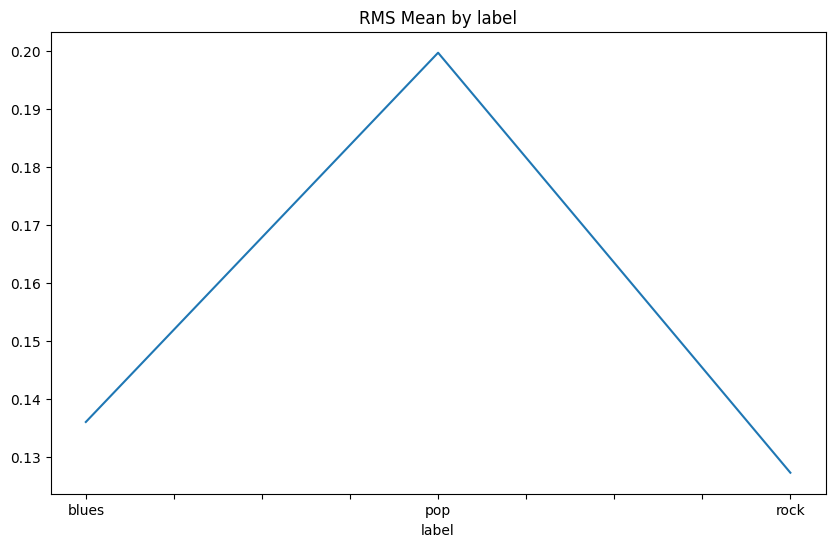

In [26]:
genre_rms = df.groupby('label')['rms_mean'].mean()
genre_rms.plot.line(figsize=(10, 6), title='RMS Mean by label')

<Figure size 640x480 with 0 Axes>

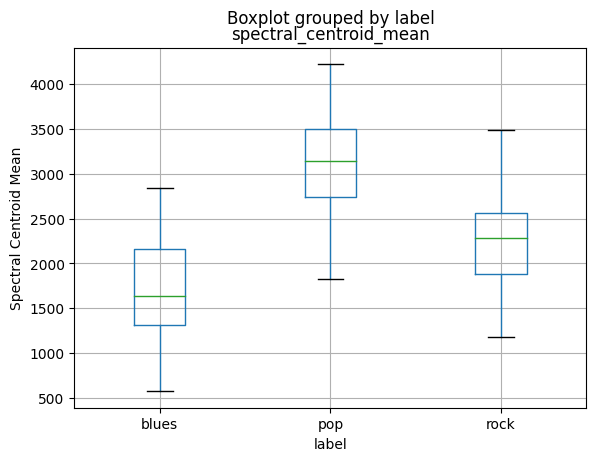

In [28]:
plt.figure()
df.boxplot(column="spectral_centroid_mean", by="label")
plt.ylabel("Spectral Centroid Mean")
plt.show()

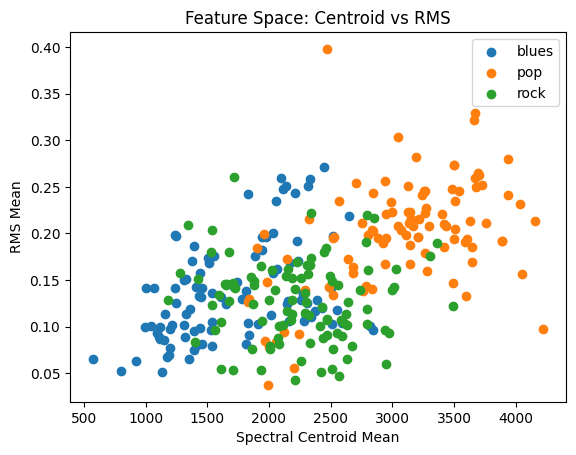

In [27]:
plt.figure()

for genre in df["label"].unique():
    subset = df[df["label"] == genre]
    plt.scatter(subset["spectral_centroid_mean"],
                subset["rms_mean"],
                label=genre)

plt.xlabel("Spectral Centroid Mean")
plt.ylabel("RMS Mean")
plt.title("Feature Space: Centroid vs RMS")
plt.legend()
plt.show()

By plotting your data in as many different ways as possible (that makes sense) and comparing values to look for features that may be strongly correlated, or data that might be highly variable, you can sometimes begin to see what features or attributes will be the most useful for solving a data science classification problem. (Note: this is not appropriate for hypothesis testing!!)

### Samples and Targets

Let's say that we are trying to figure out what musical features best predicts a song's genre. Let's say we have 1000 songs. In this case, we want to *predict* the genre for each song. That means that our model needs to output (i.e. "guess") one value per **sample** where our sample is a song or music clip.

Because you have 1000 samples, you also therefore have 1000 **target** values. Each target's value, however, can only be the name of one genre. Let's say that we know in advance that we have five genre categories. In this case, each one of those 1000 target values will just one of five categorical genre labels.

#### Predictor Variables
Let's also say that for each song we have a mean ZCR, spectral centroid, mean spectral flux, and energy. Each one of these is called a **predictor variable**. A predictor variable is a variable used in statistical regression to help *predict* another variable. 

### Supervised and Unsupervised Learning

In **supervised learning**, we take a dataset containing a set of variables (features) and their target attributes (labels). When a dataset has target attributes labeled, these labels are referred to as **ground truth**. In supervised learning, the algorithm will "learn" the relation between training examples and their associated ground truth labels and apply that learned relationship to classify (i.e., "predict") entirely *new* inputs (without labels).

In **unsupervised learning**, however, there are no labels for the targets, so its goal is to infer the natural structure present within a set of data points.

N.B.: It can be misleading to use the word "learning" here, since it makes it seem like a magical process when it is entirely mathematical.

For your next project, you will be working only with supervised learning models.

##### Supervised Learning

* Classification
* Regression

There are several common ways that supervised learning is approached and carried out. Commonly, you may hear of "classification" and "regression" models. Statistical regression is a mathematical approach for trying to predict one variable using one or more other variables. There are different *types* of regression depending on the type of data you are trying to predict (continuous or categorical) and the number of categories (e.g., is it binary or are there many categories?) 

Despite that "under the hood" all approaches are actually using similar probabilistic models, it is common to read about supervised learning where the goal is either to assign targets into *categories* ---known as a "classification" problem---or, the goal is to assign targets a value along a continuous scale---frequently described as a "regression" problem in reference to the most common type of regression: linear regression.

*Logistic* Regression is an algorithm that is used when the response or target variable is categorical. When the classification is binary, it is called *binomial* and when there are more than 2 categories it is called *multinomial*.

Thus, despite that we have these two terms, we can still *use* regression tools to carry out classification problems (more on this later).

**The idea behind ALL of these approaches is to try to find a relationship between measured features and the probability of particular outcome.**

The relationship that the algorithm "learns" between the combined set of features and an output label is then labeled **a "model."**

In [ ]:
from IPython.display import Image
Image('../images/classification_regression.png', embed=True)

#### Unsupervised Learning

Unsupervised learning is effectively a tool for self-organization of data. Given some set of input features (say, color, shape, etc.) a model tries to group objects based on features that appeared to be shared. (See example image below).  

The most common task for unsupervised learning is clustering or classification when the optimal combination of features that distinguish the data are unknown *and* there are no labels for the data. Sometimes unsupervised learning is used to learn *about* the data. 

A great example for music is so-called "functional" chord analysis. There is a system in music theory where any chord can supposedly be labeled as either "T" (tonic), "P" (predominant), or "D" (dominant). However, maybe there is a more appropriate way of categorizing Roman numerals that better accounts for the way that chords behave?

**In all of these cases, we wish to learn the inherent structure of our data without using explicitly-provided labels or a predetermined number of "states".** Since no labels are provided, there is no specific way to compare model performance in most unsupervised learning methods.

In [ ]:
Image('../images/unsupervisedLearning.png', embed=True)

#### Splitting Your Data Into Training And Test Sets

To assess your model’s performance later, you will need to divide the data set into two parts: **a training set and a test set**. The first is used to find the best combination of parameters for predicting, while the second is used to evaluate (or test the accuracy of) the learned or trained system.

You will need to divide your data **before** you start training your model. 

The most common splitting choice is to take between 2/3 and 3/4 of your original data set as the training set, while the remainder will be left aside and will compose the test set.

#### Back to supervised learning
Since “correct” output is determined entirely from the labels in the ground truth (i.e., our model assumes ground truth is "Truth"), noisy or incorrect data labels will clearly reduce the effectiveness of your model. Ground truth data labels are rarely perfect in real-world situations (especially for music!). E.g., we may have a clip with the key labeled "Eb" but there is a modulation within the clip that goes to the key of D.

For this course's final projects, you will have ground truth for all datasets, so we will be using a so-called "supervised learning" approach. 

When computing any kind of regression (or classification) model, the main considerations are:

* the complexity of the model
* the generalizability of the model

where those two factors are related. The complexity of a model refers to *how many parameters* are used altogether to make the final prediction. Using our Disney example, a complex model might rely on ALL recorded features (e.g., fur color, foot color, ear shape, beak presence, gesture pose, etc.) Generally speaking, the more complex the model, the more it will only work (or "generalize") with data that looks near-identical to the data you trained it on, and therefore it will not predict well when it sees new data. In other words, the model is learning to produce your training data without learning the actual trends or structure in the data that leads to the desired classification output. This effect is called **overfitting**.  This problem is very hard to avoid when you have a small dataset.

#### Scikit-learn

We will make use of several functions and features from the `scikit-learn` python package, which should have already been installed with everything at the beginning of the course.

Check if you already have it by entering `import sklearn` in a jupyter notebook. If it can't find the package then you'll need to install (contact me for details).

But the question is, how do you split the data? It is best to split the data in a random manner, which means you won't be good at doing it yourself (not to mention that is time consuming). To help us with this task, the `scikit` library provides a tool, called the Model Selection library. There’s a function in the library called `model_selection.train_test_split()`. Using this we can easily split the dataset into the training and the testing datasets in various proportions.

### Model Types

You will likely read about many *types* of machine learning tools and models for classification and clustering. Since explaining these approaches is beyond the scope of this class, AND we are not concerned with accuracy but rather a proof-of-concept implementation, we will simply stick with simple regression models for this class. (In other words, if you read online about things like *"SVMs", "random forsests",* or *"neural networks"* you can simply know for now that that these are all different methods for optimizing a classification model, but you shouldn't attempt to use one of them in your final projects without consulting me first.